In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
# Import the data
signal_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5")
background_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5")

# Remove nan values

signal_data = signal_data.dropna()
background_data = background_data.dropna()

# Remove regions 1-5 as they contain data not suitable for training

signal_data = signal_data[~signal_data.region.isin([1, 2, 3, 4, 5])]
background_data = background_data[~background_data.region.isin([1, 2, 3, 4, 5])]

In [14]:
# Dealing with class imbalance

# Step 1: Calculate total weight for the original background
total_background_weight = background_data['weight_nominal'].sum()

# Step 2: Randomly sample x rows from the background data
sampled_background = background_data.sample(len(signal_data), random_state=42)

# Step 3: Calculate the total weight of the sampled background (before scaling)
sampled_background_weight = sampled_background['weight_nominal'].sum()

# Step 4: Compute the scaling factor to adjust the weights
scaling_factor = total_background_weight / sampled_background_weight

# Step 5: Scale the weights of the sampled background rows
sampled_background['weight_nominal_scaled'] = sampled_background['weight_nominal'] * scaling_factor

# Step 6: Now, the total weight of the sampled background matches the original background weight
print(f"Total Original Background Weight: {total_background_weight}")
print(f"Total Sampled Background Weight (after scaling): {sampled_background['weight_nominal_scaled'].sum()}")

# Step 7: Ensure signal and background now have the same number of rows
print(f"Number of Signal Rows: {len(signal_data)}")
print(f"Number of Background Rows: {len(sampled_background)}")

# Add scaled weight ot the signal data

signal_data['weight_nominal_scaled'] = signal_data['weight_nominal']

#end

Total Original Background Weight: 0.23163864818600655
Total Sampled Background Weight (after scaling): 0.23163864818600655
Number of Signal Rows: 94755
Number of Background Rows: 94755


In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Define the features and target variable

signal_data['target'] = 1
sampled_background['target'] = 0
data = pd.concat([signal_data, sampled_background])

weights = data['weight_nominal_scaled'] # saving weights for later use

# Creation of additional useful features found from 'investigatingjets.ipynb'
# cleanedJet_eta_std, cleanedJet_eta_range, cleadJet_phi_std, cleanedJet_phi_range

# Calculate row-wise statistics for each entry in the data DataFrame
data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))



In [76]:
variables = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_phi', 'InputMet_pt', 'MHT_phi', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']

X = data[variables]
y = data['target']

X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(X, y, weights, test_size=0.2, random_state=42)


model = xgb.XGBClassifier(max_depth = 30, n_estimators = 300, learning_rate = 0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")



Accuracy: 0.6886, AUC: 0.7589


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

variables = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_phi', 'InputMet_pt', 'MHT_phi', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']

X = data[variables]
y = data['target']

X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(X, y, weights, test_size=0.2, random_state=42)

Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}


# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30, cv=2, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

TypeError: Parameter grid for parameter 'max_depth' is not iterable or a distribution (value=10)

In [68]:
# Use the best model from RandomizedSearchCV to make predictions on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")

Accuracy: 0.7012, AUC: 0.7646


In [65]:
# Plot the ROC curve
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
# plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random (AUC = 0.5)')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.show()

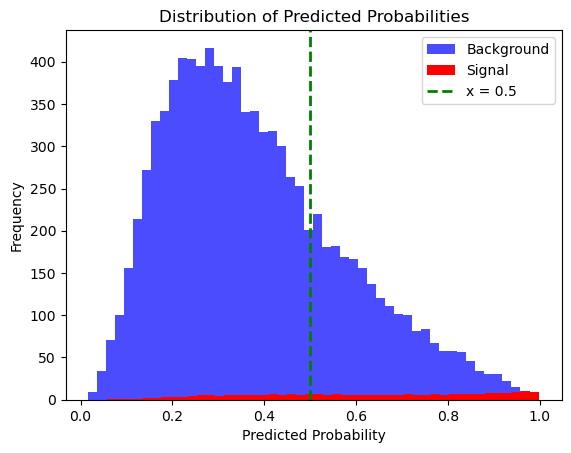

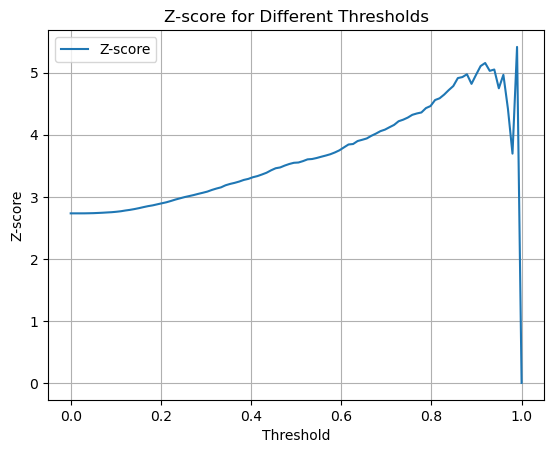

Max z-score: 5.42 at threshold: 0.99


In [63]:
# Separate the probabilities and scaled weights for signal and background
signal_proba = y_proba[y_test == 1][:, 1]
background_proba = y_proba[y_test == 0][:, 1]
signal_weights = test_weights[y_test == 1] * 200000
background_weights = test_weights[y_test == 0] * 200000

# Plot histograms for signal and background
plt.hist(
    background_proba,
    bins=50,
    color='blue',
    alpha=0.7,
    label='Background',
    weights=background_weights
)
plt.hist(
    signal_proba,
    bins=50,
    color='red',
    alpha=1,
    label='Signal',
    weights=signal_weights
)

# Add a vertical line at x = 0.5
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')

# Add labels and title
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Display the plot
plt.show()

# Now plot the Z scores

# Define thresholds to evaluate
thresholds = np.linspace(0, 1, 100)
z_scores = []

for threshold in thresholds:
    # Calculate weighted counts (areas) for signal and background on the right side of the threshold
    S = np.sum(signal_weights[signal_proba >= threshold])
    B = np.sum(background_weights[background_proba >= threshold])
    
    # Calculate Z-score if B > 0 to avoid division by zero
    if B > 0:
        Z = S / np.sqrt(B)
    else:
        Z = 0  # Or handle this case as needed
    
    z_scores.append(Z)

# Plot Z-scores against thresholds
plt.plot(thresholds, z_scores, label='Z-score')
plt.xlabel('Threshold')
plt.ylabel('Z-score')
plt.title('Z-score for Different Thresholds')
plt.legend()
plt.grid()
plt.show()

print(f"Max z-score: {max(z_scores):.2f} at threshold: {thresholds[np.argmax(z_scores)]:.2f}")

In [77]:
print(len(y_pred))

37902
